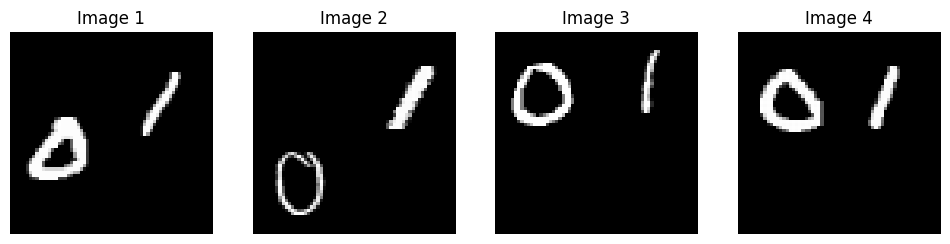

In [3]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread
root_directory = './double_mnist'
def display_images_from_folder(folder_path, num_images=4):
    image_files = os.listdir(folder_path)
    random_images = random.sample(image_files, num_images)
    
    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(folder_path, image_file)
        image = imread(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    plt.show()
train_folder = os.path.join(root_directory, 'train', '01') 
display_images_from_folder(train_folder)


# MLP On MNIST

# CNN on MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define a CNN class similar to the provided one
class MultiMNIST_CNN(nn.Module):
    def __init__(self, dropout_size=0.25, strides=2, kernel_size=3, pool_size=2):
        super(MultiMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.var1 = int((28-pool_size)/strides)+1
        self.dim = int((self.var1-pool_size)/strides)+1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_size)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set the hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Create the MultiMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.ImageFolder('./double_mnist/train/', transform=transform)
val_dataset = datasets.ImageFolder('./double_mnist/val/', transform=transform)
test_dataset = datasets.ImageFolder('./double_mnist/test/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
model = MultiMNIST_CNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Test the model
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix and classification report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

cr = classification_report(all_labels, all_preds)
print("\nClassification Report:")
print(cr)
